In [1]:
import pandas as pd
import requests
import json
import os
from dotenv import load_dotenv
from datetime import datetime
import time
import re
load_dotenv()

from datetime import datetime, timedelta
from datetime import date
import numpy as np

import psycopg2

import pathlib
import textwrap

import google.generativeai as genai #pip install -q -U google-generativeai

from IPython.display import display
from IPython.display import Markdown
import matplotlib.ticker as mticker

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

LOAD DATA FROM NASA API

In [ ]:
asteroid_list = []
url = "https://api.nasa.gov/neo/rest/v1/feed?"

start_date = "2004-12-24" 
start_date = datetime.strptime(start_date, '%Y-%m-%d')

for i in range (0, 916): 
    start_date = start_date + timedelta(days = 8)
    end_date = start_date + timedelta(days = 7)
    parameters = {
        "start_date" : start_date,
        "end_date" : end_date,
        "api_key": os.getenv("nasa_key")
    }

    response = requests.get(url, params=parameters)
    if response.status_code == 200:
        data = response.json()
        filtered_data  = data['near_earth_objects']
        asteroid_list.append(filtered_data)
    else:
        # Si la requête échoue, on retourne un message d'erreur avec le code de statut
        print(f"Error {response.status_code}: {response.json().get('message', 'Unknown error')}")
    print(start_date, end_date)
    time.sleep(7)

asteroid_dict = {}
empty_dict = {}
final_dict = {} # il ne peut pas avoir le même nom de clé, on ne peut pas mettre la date

count = 0

# Première boucle : range de i = le nombre de boucles 
for i in range(0, len(asteroid_list)):
    asteroid_dict[i] = asteroid_list[i]
    # Deuxième boucle : k = la date
    for k, v in asteroid_dict[i].items(): 
        empty_dict[k] = asteroid_dict[i][k]

# Troisième boucle : pour récupérer les infos asteroides à l'intérieure de chaque date
# pour une date il y a en moyenne entre 10-15 asteroides
for k, v in empty_dict.items(): 
    for m in range(0, len(empty_dict[k])):
        count += 1 
        try: 
            final_dict[count] = {
                'date': k, 
                'id' : empty_dict[k][m]['id'],
                'name': empty_dict[k][m]['name'],
                'absolute_magnitude_h': empty_dict[k][m]['absolute_magnitude_h'], 
                'estimated_diameter_min_meters' : empty_dict[k][m]['estimated_diameter']['meters']['estimated_diameter_min'],
                'estimated_diameter_max_meters' : empty_dict[k][m]['estimated_diameter']['meters']['estimated_diameter_max'], 
                'is_potentially_hazardous_asteroid' : empty_dict[k][m]['is_potentially_hazardous_asteroid'], 
                'is_sentry_object' : empty_dict[k][m]['is_sentry_object'],
                'close_approach_date': empty_dict[k][m]['close_approach_data'][0]['close_approach_date'], 
                'close_approach_date_full': empty_dict[k][m]['close_approach_data'][0]['close_approach_date_full'],
                'relative_velocity_km_per_second': empty_dict[k][m]['close_approach_data'][0]['relative_velocity']['kilometers_per_second'],
                'relative_velocity_km_per_hour' : empty_dict[k][m]['close_approach_data'][0]['relative_velocity']['kilometers_per_hour'], 
                'miss_distance_kilometers' : empty_dict[k][m]['close_approach_data'][0]['miss_distance']['kilometers'], 
                'orbiting_body' : empty_dict[k][m]['close_approach_data'][0]['orbiting_body']
                           }

        except: 
            continue

df_all_data = pd.DataFrame.from_dict(final_dict, orient='index')
df_all_data.to_parquet("df_all_data.parquet")

2005-01-01 00:00:00 2005-01-08 00:00:00
2005-01-09 00:00:00 2005-01-16 00:00:00


In [4]:
df_asteroides = pd.read_parquet("df_all_data.parquet")
df_asteroides.shape
df_asteroides = df_asteroides.sort_values(by='date').reset_index(drop=True)
df_asteroides['date'] = pd.to_datetime(df_asteroides['date'])
df_asteroides['close_approach_date'] = pd.to_datetime(df_asteroides['close_approach_date'])
df_asteroides.head()

,date,id,name,absolute_magnitude_h,estimated_diameter_min_meters,estimated_diameter_max_meters,is_potentially_hazardous_asteroid,is_sentry_object,close_approach_date,close_approach_date_full,relative_velocity_km_per_second,relative_velocity_km_per_hour,miss_distance_kilometers,orbiting_body
0,2005-01-01,3263538,(2004 XM29),22.90,69.912523,156.329154,False,False,2005-01-01,2005-Jan-01 10:34,14.3968009305,51828.483349714,3557666.023904082,Earth
1,2005-01-01,2106538,106538 (2000 WK63),16.29,1467.421834,3281.254972,False,False,2005-01-01,2005-Jan-01 08:06,33.7772931927,121598.2554938791,58238701.157995232,Earth
2,2005-01-01,3723817,(2015 MO116),24.00,42.126461,94.197631,False,False,2005-01-01,2005-Jan-01 10:19,10.4849802145,37745.9287721539,69869426.439024048,Earth
3,2005-01-01,54101660,(2020 YQ1),23.27,58.959661,131.837810,False,False,2005-01-01,2005-Jan-01 23:28,11.6618815967,41982.773748035,16520775.264542727,Earth
4,2005-01-01,54105994,(2021 AX6),26.89,11.131533,24.890864,False,True,2005-01-01,2005-Jan-01 22:31,20.2575200376,72927.0721354417,58766568.432210908,Earth


In [15]:
df_asteroides[df_asteroides.duplicated(subset='close_approach_date_full')== True]

,date,id,name,absolute_magnitude_h,estimated_diameter_min_meters,estimated_diameter_max_meters,is_potentially_hazardous_asteroid,is_sentry_object,close_approach_date,close_approach_date_full,relative_velocity_km_per_second,relative_velocity_km_per_hour,miss_distance_kilometers,orbiting_body
29,2005-01-03,3063823,(2000 WP19),22.700,76.657557,171.411509,False,False,2005-01-03,2005-Jan-03 05:31,6.8787823894,24763.6166019855,23181641.624310906,Earth
191,2005-01-21,3265792,(2005 AQ19),21.410,138.852907,310.484539,False,False,2005-01-21,2005-Jan-21 03:40,8.6204110488,31033.479775536,44172607.40527828,Earth
312,2005-02-01,2612343,612343 (2002 FT6),22.660,78.082728,174.598287,False,False,2005-02-01,2005-Feb-01 07:00,7.7848532301,28025.4716283934,51095528.512746245,Earth
320,2005-02-02,3630638,(2013 EU9),21.660,123.752784,276.719637,False,False,2005-02-02,2005-Feb-02 04:51,4.0722303853,14660.0293869169,52584377.138905453,Earth
460,2005-02-16,54246997,(2022 AC30),19.290,368.599699,824.213984,False,False,2005-02-16,2005-Feb-16 17:09,9.4059831602,33861.5393767392,58389715.914301363,Earth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109572,2024-12-18,3350633,(2006 TU7),21.900,110.803882,247.765013,True,False,2024-12-18,2024-Dec-18 04:45,10.9998758957,39599.5532243404,59453068.315388429,Earth
109585,2024-12-19,2618348,618348 (2016 PN),20.220,240.190030,537.081235,False,False,2024-12-19,2024-Dec-19 06:26,16.4096537414,59074.7534690537,55621520.14170513,Earth
109740,2024-12-27,2612199,612199 (2000 WL63),19.990,267.026877,597.090249,False,False,2024-12-27,2024-Dec-27 04:04,10.7484291374,38694.3448947826,24721575.903503869,Earth
109750,2024-12-27,54419702,(2024 AX2),22.810,72.871041,162.944602,False,False,2024-12-27,2024-Dec-27 22:01,20.7063030837,74542.6911012779,48193226.657095306,Earth


In [32]:
df_asteroides.isna().sum()

date                                 0
id                                   0
name                                 0
absolute_magnitude_h                 0
estimated_diameter_min_meters        0
estimated_diameter_max_meters        0
is_potentially_hazardous_asteroid    0
is_sentry_object                     0
close_approach_date                  0
close_approach_date_full             0
relative_velocity_km_per_second      0
relative_velocity_km_per_hour        0
miss_distance_kilometers             0
orbiting_body                        0
dtype: int64

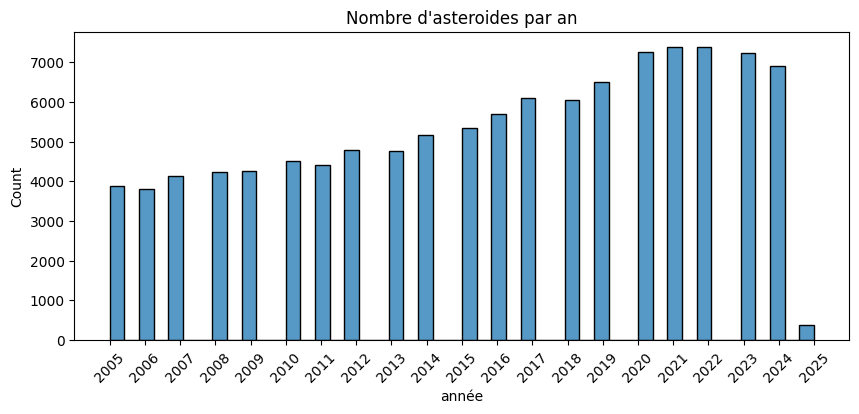

In [24]:
plt.figure(figsize=(10, 4))
year = df_asteroides['date'].dt.year
sns.histplot(data=df_asteroides, x=year)
plt.title("Nombre d'asteroides par an")
plt.xlabel('année')

years = np.arange(year.min(), year.max() + 1)  # Générer toutes les années de min à max
plt.xticks(years, rotation=45)

plt.show()

In [5]:
df_test = df_asteroides.drop_duplicates(subset='id').reset_index(drop=True)
print(df_test.shape)
df_test.to_parquet("df_test.parquet")
df_test.head()

(34979, 14)


,date,id,name,absolute_magnitude_h,estimated_diameter_min_meters,estimated_diameter_max_meters,is_potentially_hazardous_asteroid,is_sentry_object,close_approach_date,close_approach_date_full,relative_velocity_km_per_second,relative_velocity_km_per_hour,miss_distance_kilometers,orbiting_body
0,2005-01-01,3263538,(2004 XM29),22.90,69.912523,156.329154,False,False,2005-01-01,2005-Jan-01 10:34,14.3968009305,51828.483349714,3557666.023904082,Earth
1,2005-01-01,2106538,106538 (2000 WK63),16.29,1467.421834,3281.254972,False,False,2005-01-01,2005-Jan-01 08:06,33.7772931927,121598.2554938791,58238701.157995232,Earth
2,2005-01-01,3723817,(2015 MO116),24.00,42.126461,94.197631,False,False,2005-01-01,2005-Jan-01 10:19,10.4849802145,37745.9287721539,69869426.439024048,Earth
3,2005-01-01,54101660,(2020 YQ1),23.27,58.959661,131.837810,False,False,2005-01-01,2005-Jan-01 23:28,11.6618815967,41982.773748035,16520775.264542727,Earth
4,2005-01-01,54105994,(2021 AX6),26.89,11.131533,24.890864,False,True,2005-01-01,2005-Jan-01 22:31,20.2575200376,72927.0721354417,58766568.432210908,Earth


DATA ENRICHMENT WITH AI

In [ ]:
df = pd.read_parquet(".ignore/df_test.parquet")
df.head(3)

,date,id,name,absolute_magnitude_h,estimated_diameter_min_meters,estimated_diameter_max_meters,is_potentially_hazardous_asteroid,is_sentry_object,close_approach_date,close_approach_date_full,relative_velocity_km_per_second,relative_velocity_km_per_hour,miss_distance_kilometers,orbiting_body
0,2005-01-01,3263538,(2004 XM29),22.90,69.912523,156.329154,False,False,2005-01-01,2005-Jan-01 10:34,14.3968009305,51828.483349714,3557666.023904082,Earth
1,2005-01-01,2106538,106538 (2000 WK63),16.29,1467.421834,3281.254972,False,False,2005-01-01,2005-Jan-01 08:06,33.7772931927,121598.2554938791,58238701.157995232,Earth
2,2005-01-01,3723817,(2015 MO116),24.00,42.126461,94.197631,False,False,2005-01-01,2005-Jan-01 10:19,10.4849802145,37745.9287721539,69869426.439024048,Earth


In [ ]:
GOOGLE_API_KEY=os.getenv("google_api_key")
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-1.5-flash')

data_dict = {}

for i in range(0, len(df)): 
    response = model.generate_content(f"""Tu es un Astrophysicien spécialisé dans les astéroïdes. Réponds aux questions et donne moi uniquement les réponses sous forme de liste []:
            - décrit l'astéroïde {df.loc[i, "name"]} en moins de 600 caractères
            - date de découverte sous format année-mois-date
            - masse estimée en kg ou None
            - choisis une réponse de la liste: type C (carbonés), type S (silicatés), type M (métalliques), Inconnu
            - date d'entrée atmosphérique : date ou None
            - choisis une ou des réponses de la liste: Boules de feu ou bolides, Traînées de fumée ou de plasma, Tremblements de terre aériens (Bang supersonique), Éclats de lumière ou explosions atmosphériques, Chutes de météorites, Phénomènes observés lors de survols proches (Near-Earth Flybys), Impacts terrestres, Aucun à ce jour
            - Lieu d'impact terrestre : ville, région, pays, continent ou None
            - décrit la mission d'exploration spatiale en moins de 600 caractères ou None
            - longitude du lieu d'impact terrestre ou None
            - latitude du lieu d'impact terrestre ou None
    """)
    name = df.loc[i, "name"]
    response = response.text
    r = response.replace("```\n[\n", "").replace("]\n```\n", "").replace("* ", "").replace("[", "").replace("]", "").replace("\n\n", "\n").replace("```", "").replace("- ", "").split("\n")
    test = [item for item in r if item]
    data_dict[name] = test

df1 = pd.DataFrame.from_dict(data_dict, orient='index', columns=['description', 'date_decouverte', 'masse_estimee_kg', 
                            'type', 'date_entree_athmospherique', 'phenomene_observee', 'lieu_impact', 'mission', 'latitude', 'longitude']).reset_index().rename(columns={'index' : 'name'})
df1

MERGE DATA FRAMES

In [3]:
df_asteroides = pd.read_parquet(".ignore/df_asteroides.parquet")
df_asteroides.head(3)

,date,id,name,absolute_magnitude_h,estimated_diameter_min_meters,estimated_diameter_max_meters,is_potentially_hazardous_asteroid,is_sentry_object,close_approach_date,close_approach_date_full,relative_velocity_km_per_second,relative_velocity_km_per_hour,miss_distance_kilometers,orbiting_body
0,2005-01-01,3263538,(2004 XM29),22.90,69.912523,156.329154,False,False,2005-01-01,2005-Jan-01 10:34,14.3968009305,51828.483349714,3557666.023904082,Earth
1,2005-01-01,2106538,106538 (2000 WK63),16.29,1467.421834,3281.254972,False,False,2005-01-01,2005-Jan-01 08:06,33.7772931927,121598.2554938791,58238701.157995232,Earth
2,2005-01-01,3723817,(2015 MO116),24.00,42.126461,94.197631,False,False,2005-01-01,2005-Jan-01 10:19,10.4849802145,37745.9287721539,69869426.439024048,Earth


In [4]:
df1 = pd.read_parquet(".ignore/df1_completed.parquet")
df2 = pd.read_parquet(".ignore/df2_completed.parquet")
df3 = pd.read_parquet(".ignore/df3_completed.parquet")
df4 = pd.read_parquet(".ignore/df4_completed.parquet")
df5 = pd.read_parquet(".ignore/df5_completed.parquet")
df_concat =  pd.concat([df1, df2, df3, df4, df5])
print(df_concat.shape)

(34981, 9)


In [5]:
df_merged= pd.merge(df_asteroides, df_concat, how='left', on='name').reset_index(drop=True)
print(df_merged.shape)
pd.get_option("display.max_columns")
df_merged.head(3)

(110207, 22)


,date,id,name,absolute_magnitude_h,estimated_diameter_min_meters,estimated_diameter_max_meters,is_potentially_hazardous_asteroid,is_sentry_object,close_approach_date,close_approach_date_full,...,miss_distance_kilometers,orbiting_body,description,date_decouverte,masse_estimee_kg,type,date_entree_athmospherique,phenomene_observee,lieu_impact,mission
0,2005-01-01,3263538,(2004 XM29),22.90,69.912523,156.329154,False,False,2005-01-01,2005-Jan-01 10:34,...,3557666.023904082,Earth,"Astéroïde de la ceinture principale, relativem...",2004-12-10,NULL,Type S (silicatés),NULL,Aucun à ce jour,Aucun,Aucun
1,2005-01-01,2106538,106538 (2000 WK63),16.29,1467.421834,3281.254972,False,False,2005-01-01,2005-Jan-01 08:06,...,58238701.157995232,Earth,"Astéroïde de la ceinture principale, relativem...",2000-11-26,NULL,Inconnu,NULL,Aucun à ce jour,Aucun,Aucun
2,2005-01-01,3723817,(2015 MO116),24.00,42.126461,94.197631,False,False,2005-01-01,2005-Jan-01 10:19,...,69869426.439024048,Earth,"Astéroïde de taille moyenne, potentiellement d...",2015-06-29,NULL,Inconnu,NULL,Aucun à ce jour,Aucun,Aucun


RENAME COLUMNS

In [6]:
df_merged = df_merged.rename(columns={
    'name' : 'nom', 
    'absolute_magnitude_h': 'magnitude_absolue', 
    'estimated_diameter_min_meters' : 'diametre_estime_min_m', 
    'estimated_diameter_max_meters' : 'diametre_estime_max_m',
    'is_potentially_hazardous_asteroid' : 'potentiellement_dangeureux',
    'is_sentry_object' : 'sentry_surveillance_collisions',
    'close_approach_date': 'date_approche',
    'close_approach_date_full' : 'date_approche_complete',
    'relative_velocity_km_per_second' : 'vitesse_relative_km_par_seconde', 
    'relative_velocity_km_per_hour' : 'vitesse_relative_km_par_heure',
    'miss_distance_kilometers' : 'distance_de_la_terre',
    'orbiting_body' : 'orbite'
 })

CHANGE COLUMN TYPES

In [7]:
df_merged.dtypes

date                               datetime64[ns]
id                                         object
nom                                        object
magnitude_absolue                         float64
diametre_estime_min_m                     float64
diametre_estime_max_m                     float64
potentiellement_dangeureux                   bool
sentry_surveillance_collisions               bool
date_approche                      datetime64[ns]
date_approche_complete                     object
vitesse_relative_km_par_seconde            object
vitesse_relative_km_par_heure              object
distance_de_la_terre                       object
orbite                                     object
description                                object
date_decouverte                            object
masse_estimee_kg                           object
type                                       object
date_entree_athmospherique                 object
phenomene_observee                         object


In [8]:
df_merged['date_approche_complete'] = df_merged['date_approche_complete'].apply(
    lambda x : datetime.strptime(x, '%Y-%b-%d %H:%M'))

In [9]:
# Transformer les colonnes numériques en float
df_merged[['vitesse_relative_km_par_seconde','vitesse_relative_km_par_heure', 
'distance_de_la_terre']] = df_merged[['vitesse_relative_km_par_seconde',
'vitesse_relative_km_par_heure', 'distance_de_la_terre']].astype('float64')

CLEANING DATA

In [10]:
# Nettoyage des charactères spéciaux 
df_merged['description'] = df_merged['description'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['date_decouverte'] = df_merged['date_decouverte'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['masse_estimee_kg'] = df_merged['masse_estimee_kg'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['date_entree_athmospherique'] = df_merged['date_entree_athmospherique'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['phenomene_observee'] = df_merged['phenomene_observee'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['lieu_impact'] = df_merged['lieu_impact'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

df_merged['mission'] = df_merged['mission'].astype(str).apply(
    lambda x : re.sub(r'[*]|-\s', '', x))

In [11]:
def transform_to_date(x) -> date| None: 
        try:
            var_date = datetime.strptime(x, '%Y-%m-%d')
        except: 
            var_date = None
        return var_date

df_merged['date_entree_athmospherique'] = df_merged['date_entree_athmospherique'].apply(transform_to_date)
df_merged['date_decouverte'] = df_merged['date_decouverte'].apply(transform_to_date)

In [12]:
dirty_list = ["Masse estimée: NULL", "Masse estimée:NULL", "Lieu d'impact terrestre: Aucun", "Aucun",
              "Mission d'exploration spatiale: Aucun", 'Aucun à ce jour', "Aucun à ce jour.",
              "Phénomènes observés: Aucun à ce jour", "Mission d'exploration spatiale:Aucun", "NULL", 
              "Lieu d'impact terrestre:Aucun", "Phénomènes observés:Aucun à ce jour."]

def cleaning(word : str) -> str: 
    if word in dirty_list and isinstance(word, str): 
        word = None
    else : word = word
    return word

In [13]:
df_merged['date_decouverte'] = df_merged['date_decouverte'].apply(cleaning)
df_merged['masse_estimee_kg'] = df_merged['masse_estimee_kg'].apply(cleaning)
df_merged['date_entree_athmospherique'] = df_merged['date_entree_athmospherique'].apply(cleaning)
df_merged['phenomene_observee'] = df_merged['phenomene_observee'].apply(cleaning)
df_merged['lieu_impact'] = df_merged['lieu_impact'].apply(cleaning)
df_merged['mission'] = df_merged['mission'].apply(cleaning)

In [14]:
# Nettoyage de la colonne type
df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^(Type Apollo|Type Inconnu|Type: Inconnu|Type X|Type:Inconnu).*', 'Inconnu', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type S.*', 'Type S (silicatés)', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type M.*', 'Type M (métalliques)', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type C.*', 'Type C (carbonés)', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type B.*', 'Type B (sous-type de C)', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type L.*', 'Type L (entre S (silicatés) et C (carbonés))', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type V.*', 'Type V (basaltique)', x, flags=re.IGNORECASE))

df_merged['type'] = df_merged['type'].astype(str).apply(
    lambda x : re.sub(r'^Type Q.*', 'Type Q (Olivine, Pyroxène, Métaux (fer-nickel), Silicates non altérés)', x, flags=re.IGNORECASE))

In [15]:
# Nettoyage de la colonne masse 
def exposant_unicode(match):
    exposants = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    return match.group(1) + match.group(2).translate(exposants)

def transform_masse (masse : str) -> str:
    if isinstance (masse, str): 
        masse = masse.replace(",", ".").replace('</sup>', '').replace('\u202f', ' ')
        pattern = r"(\d+)(?:\^|<sup>)(\d+)(?:</sup>)?"
        formatted_masse = re.sub(pattern, exposant_unicode, masse)
        return formatted_masse

df_merged['masse_estimee_kg'] = df_merged['masse_estimee_kg'].apply(lambda x : transform_masse(x) if isinstance(x, str) else x)

In [16]:
# Remplacer les "Nones" en str par None
df_merged[['description', 'date_decouverte', 'masse_estimee_kg', 'type',
    'date_entree_athmospherique', 'phenomene_observee', 'lieu_impact',
    'mission']] = df_merged[['description', 'date_decouverte', 'masse_estimee_kg', 'type',
    'date_entree_athmospherique', 'phenomene_observee', 'lieu_impact',
    'mission']].apply(lambda x : x.replace('None', None))

In [17]:
# Remplacer les "nan" en str par None
df_merged[['description', 'date_decouverte', 'masse_estimee_kg', 'type',
    'date_entree_athmospherique', 'phenomene_observee', 'lieu_impact',
    'mission']] = df_merged[['description', 'date_decouverte', 'masse_estimee_kg', 'type',
    'date_entree_athmospherique', 'phenomene_observee', 'lieu_impact',
    'mission']].apply(lambda x : x.replace('nan', None))

In [18]:
df_merged.dtypes

date                               datetime64[ns]
id                                         object
nom                                        object
magnitude_absolue                         float64
diametre_estime_min_m                     float64
diametre_estime_max_m                     float64
potentiellement_dangeureux                   bool
sentry_surveillance_collisions               bool
date_approche                      datetime64[ns]
date_approche_complete             datetime64[ns]
vitesse_relative_km_par_seconde           float64
vitesse_relative_km_par_heure             float64
distance_de_la_terre                      float64
orbite                                     object
description                                object
date_decouverte                    datetime64[ns]
masse_estimee_kg                           object
type                                       object
date_entree_athmospherique         datetime64[ns]
phenomene_observee                         object


In [19]:
def clean_country(country : str) -> str: 
    if country == 'Botswana' and isinstance(country, str): 
        country = 'Botswana, Afrique'
    else: country
    return country

df_merged['lieu_impact'] = df_merged['lieu_impact'].apply(clean_country)

In [20]:
coordonnees = {
    "Botswana": (-22.3285, 24.6849),
    "Soudan": (12.8628, 30.2176),
    "Mer du Nord": (56.5, 3.0),
    "Mer de la Manche, France, Europe": (49.5, -1.0),
    "Océan Indien": (-20.0, 80.0),
    "Normandie, France": (49.2, 0.7),
    "Mer de Norvège": (68.0, 5.0),
    'Méditerranée': (38.0, 18.0), # Point central en Méditerranée
    'Océan Atlantique' : (0.0, -30.0), # Milieu de l'Atlantique
    'Océan Pacifique' : (0.0, -140.0) # Milieu du Pacifique
}

In [21]:
df_merged['latitude'] = df_merged['lieu_impact'].map({
    'Botswana, Afrique' : -22.3285,
    'Soudan': 12.8628, 
    'Mer du Nord' : 56.5,
    'Mer de la Manche, France, Europe': 49.5,
    'Océan Indien': -20.0,
    'Normandie, France' : 49.2,
    'Mer de Norvège': 68.0,
    'Méditerranée': 38.0, 
    'Océan Atlantique' : 0.0, 
    'Océan Pacifique' : 0.0,
    "Atlantique, au large de la côte de l'Amérique du Sud." : -10.0,
    None : None
    })

In [22]:
df_merged['longitude'] = df_merged['lieu_impact'].map({
    'Botswana, Afrique' : 24.6849,
    'Soudan': 30.2176, 
    'Mer du Nord' : 3.0,
    'Mer de la Manche, France, Europe': -1.0,
    'Océan Indien': 80.0,
    'Normandie, France' : 0.7,
    'Mer de Norvège': 5.0,
    'Méditerranée': 18.0, 
    'Océan Atlantique' :-30.0, 
    'Océan Pacifique' : -140.0,
    "Atlantique, au large de la côte de l'Amérique du Sud." : -30.0,
    None : None
    })

In [33]:
df_merged[df_merged['phenomene_observee'] == " Boules de feu ou bolides, Éclats de lumière ou explosions atmosphériques"]

,date,id,nom,magnitude_absolue,diametre_estime_min_m,diametre_estime_max_m,potentiellement_dangeureux,sentry_surveillance_collisions,date_approche,date_approche_complete,...,description,date_decouverte,masse_estimee_kg,type,date_entree_athmospherique,phenomene_observee,lieu_impact,mission,latitude,longitude
81546,2021-02-04,54110061,(2021 CZ),27.1,10.105434,22.596438,False,False,2021-02-04,2021-02-04 15:31:00,...,Petit astéroïde de quelques mètres de diamètre...,2021-02-04,None,Inconnu,2021-02-05,"Boules de feu ou bolides, Éclats de lumière o...",None,None,NaN,NaN


In [34]:
df_merged.loc[81546, 'phenomene_observee']

' Boules de feu ou bolides, Éclats de lumière ou explosions atmosphériques'

In [36]:
df_merged.loc[81546, 'phenomene_observee'] = df_merged.loc[81546, 'phenomene_observee'].replace(" Boules de feu ou bolides, Éclats de lumière ou explosions atmosphériques", "Boules de feu ou bolides, Éclats de lumière ou explosions atmosphériques")

In [38]:
df_merged['phenomene_observee'].unique()

array([None,
       'Boules de feu ou bolides, Traînées de fumée ou de plasma, Éclats de lumière ou explosions atmosphériques',
       'Phénomènes observés lors de survols proches (Near-Earth Flybys)',
       'Impacts terrestres', 'Boules de feu ou bolides',
       'Boules de feu ou bolides, Éclats de lumière ou explosions atmosphériques',
       'Éclats de lumière ou explosions atmosphériques',
       'Bolides, Éclats de lumière ou explosions atmosphériques',
       'Impacts terrestres, Éclats de lumière ou explosions atmosphériques',
       'Impacts terrestres, Boules de feu ou bolides',
       'Entrée atmosphérique et explosions atmosphériques',
       'Bolides, Éclats de lumière ou explosions atmosphériques, Chutes de météorites',
       'Boules de feu ou bolides, Chutes de météorites, Impacts terrestres',
       'Boules de feu ou bolides, Traînées de fumée ou de plasma',
       'Boules de feu ou bolides, Chutes de météorites',
       'Boules de feu ou bolides, Traînées de fumée ou

In [25]:
df_merged.head(1)

,date,id,nom,magnitude_absolue,diametre_estime_min_m,diametre_estime_max_m,potentiellement_dangeureux,sentry_surveillance_collisions,date_approche,date_approche_complete,...,description,date_decouverte,masse_estimee_kg,type,date_entree_athmospherique,phenomene_observee,lieu_impact,mission,latitude,longitude
0,2005-01-01,3263538,(2004 XM29),22.9,69.912523,156.329154,False,False,2005-01-01,2005-01-01 10:34:00,...,"Astéroïde de la ceinture principale, relativem...",2004-12-10,None,Type S (silicatés),NaT,None,None,None,NaN,NaN


In [27]:
df_merged.tail()

,date,id,nom,magnitude_absolue,diametre_estime_min_m,diametre_estime_max_m,potentiellement_dangeureux,sentry_surveillance_collisions,date_approche,date_approche_complete,...,description,date_decouverte,masse_estimee_kg,type,date_entree_athmospherique,phenomene_observee,lieu_impact,mission,latitude,longitude
110202,2025-01-23,54246383,(2022 CX4),27.88,7.055942,15.777565,False,False,2025-01-23,2025-01-23 22:51:00,...,Petit astéroïde détecté peu avant son entrée a...,2022-02-12,None,Inconnu,2022-02-12,"Boules de feu ou bolides, Traînées de fumée ou...",None,None,NaN,NaN
110203,2025-01-23,54194348,(2021 RX5),23.72,47.924212,107.161795,False,False,2025-01-23,2025-01-23 20:18:00,...,"Astéroïde de taille moyenne, potentiellement d...",2021-09-08,None,Inconnu,NaT,Phénomènes observés lors de survols proches (N...,None,None,NaN,NaN
110204,2025-01-23,54054459,(2020 RS9),23.90,44.111820,98.637028,False,False,2025-01-23,2025-01-23 05:05:00,...,"Astéroïde de petite taille, relativement peu é...",2020-09-15,None,Inconnu,NaT,None,None,None,NaN,NaN
110205,2025-01-23,3797709,(2018 AH13),23.90,44.111820,98.637028,False,False,2025-01-23,2025-01-23 09:01:00,...,(2018 AH13) est un astéroïde géocroiseur de pe...,2018-01-06,None,Inconnu,NaT,Phénomènes observés lors de survols proches (N...,None,None,NaN,NaN
110206,2025-01-23,2162080,162080 (1998 DG16),19.95,271.991277,608.190985,False,False,2025-01-23,2025-01-23 04:03:00,...,"Astéroïde de la ceinture principale, de taille...",1998-02-21,None,Inconnu,NaT,None,None,None,NaN,NaN


In [39]:
df_merged.dtypes

date                               datetime64[ns]
id                                         object
nom                                        object
magnitude_absolue                         float64
diametre_estime_min_m                     float64
diametre_estime_max_m                     float64
potentiellement_dangeureux                   bool
sentry_surveillance_collisions               bool
date_approche                      datetime64[ns]
date_approche_complete             datetime64[ns]
vitesse_relative_km_par_seconde           float64
vitesse_relative_km_par_heure             float64
distance_de_la_terre                      float64
orbite                                     object
description                                object
date_decouverte                    datetime64[ns]
masse_estimee_kg                           object
type                                       object
date_entree_athmospherique         datetime64[ns]
phenomene_observee                         object


In [40]:
df_merged.to_parquet(".ignore/df_asteroides_final.parquet", index=False)

In [5]:
df_asteroids_final = pd.read_parquet(".ignore/df_asteroids_final.parquet")
df_asteroids_final

,date,id,nom,magnitude_absolue,diametre_estime_min_m,diametre_estime_max_m,potentiellement_dangeureux,sentry_surveillance_collisions,date_approche,date_approche_complete,...,description,date_decouverte,masse_estimee_kg,type,date_entree_athmospherique,phenomene_observee,lieu_impact,mission,latitude,longitude
0,2005-01-01,3263538,(2004 XM29),22.90,69.912523,156.329154,False,False,2005-01-01,2005-01-01 10:34:00,...,"Astéroïde de la ceinture principale, relativem...",2004-12-10,None,Type S (silicatés),NaT,None,None,None,NaN,NaN
1,2005-01-01,2106538,106538 (2000 WK63),16.29,1467.421834,3281.254972,False,False,2005-01-01,2005-01-01 08:06:00,...,"Astéroïde de la ceinture principale, relativem...",2000-11-26,None,Inconnu,NaT,None,None,None,NaN,NaN
2,2005-01-01,3723817,(2015 MO116),24.00,42.126461,94.197631,False,False,2005-01-01,2005-01-01 10:19:00,...,"Astéroïde de taille moyenne, potentiellement d...",2015-06-29,None,Inconnu,NaT,None,None,None,NaN,NaN
3,2005-01-01,54101660,(2020 YQ1),23.27,58.959661,131.837810,False,False,2005-01-01,2005-01-01 23:28:00,...,"Astéroïde de petite taille, découvert récemmen...",2020-12-28,None,Inconnu,NaT,None,None,None,NaN,NaN
4,2005-01-01,54105994,(2021 AX6),26.89,11.131533,24.890864,False,True,2005-01-01,2005-01-01 22:31:00,...,(2021 AX6) est un astéroïde Apollon de petite ...,2021-01-06,None,Inconnu,NaT,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110202,2025-01-23,54246383,(2022 CX4),27.88,7.055942,15.777565,False,False,2025-01-23,2025-01-23 22:51:00,...,Petit astéroïde détecté peu avant son entrée a...,2022-02-12,None,Inconnu,2022-02-12,"Boules de feu ou bolides, Traînées de fumée ou...",None,None,NaN,NaN
110203,2025-01-23,54194348,(2021 RX5),23.72,47.924212,107.161795,False,False,2025-01-23,2025-01-23 20:18:00,...,"Astéroïde de taille moyenne, potentiellement d...",2021-09-08,None,Inconnu,NaT,Phénomènes observés lors de survols proches (N...,None,None,NaN,NaN
110204,2025-01-23,54054459,(2020 RS9),23.90,44.111820,98.637028,False,False,2025-01-23,2025-01-23 05:05:00,...,"Astéroïde de petite taille, relativement peu é...",2020-09-15,None,Inconnu,NaT,None,None,None,NaN,NaN
110205,2025-01-23,3797709,(2018 AH13),23.90,44.111820,98.637028,False,False,2025-01-23,2025-01-23 09:01:00,...,(2018 AH13) est un astéroïde géocroiseur de pe...,2018-01-06,None,Inconnu,NaT,Phénomènes observés lors de survols proches (N...,None,None,NaN,NaN
